# Leverage reflectance data cube to detect field practices

This notebook illustrate how to highlight a tillage event using a reflectance datacube stored on cloud storage. 

For this example the data cube has been generated using https://github.com/GEOSYS/earthdaily-data-processor with the following parameters:
- Geometry: "POLYGON ((-100.501616 38.292731, -100.501654 38.299973, -100.492568 38.299801, -100.492568 38.292711, -100.501616 38.292731))"
- Collection: Sentinel-2-l2a
- Dates: 2021-04-04 to 2021-06-25
- Assets: red, nir, swir16, swir22

In [1]:
import sys
import os
sys.path.append(os.path.join('..','src'))
from geosyspy.utils.constants import *
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from utils.utils import open_cube_azure

## 1️⃣ Load Datacube from Cloud Storage

- Open Datacube from Azure Cloud Storage

In [3]:
#image = '2021-04-04_2021-06-25_Sustainability_sentinel-2-l2a_datacube.zarr'
image = '2021-03-01_2021-07-31_tillage_field_sentinel-2-l2a_datacube.zarr'
cube = open_cube_azure(image)

## 2️⃣ Plot NDTI images around tillage dates

Winter wheat on this field with harvest at the beginning of June 2021 then tillage a few days after.

In [4]:
def NDTI(swir16,swir22):
    return((swir16 - swir22)/(swir16 + swir22))

In [5]:
cube_date_int = cube.sel(time=['2021-04-05T00:00:00.000000000','2021-04-10T00:00:00.000000000', 
                               '2021-04-20T00:00:00.000000000','2021-04-25T00:00:00.000000000', 
                               '2021-04-30T00:00:00.000000000','2021-05-07T00:00:00.000000000',
                               '2021-05-27T00:00:00.000000000', '2021-06-06T00:00:00.000000000',
                               '2021-06-11T00:00:00.000000000', '2021-06-14T00:00:00.000000000',
                               '2021-06-16T00:00:00.000000000', '2021-06-21T00:00:00.000000000'])

In [6]:
dates=[]
NDTIs=[]
for date,cube_date in cube_date_int.groupby('time'):
    NDTIs.append(NDTI(cube_date.swir16,cube_date.swir22))
    dates.append(date)
print(len(NDTIs))

C:\Users\kls\AppData\Local\Temp\ipykernel_65720\199987079.py:3: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for date,cube_date in cube_date_int.groupby('time'):


12


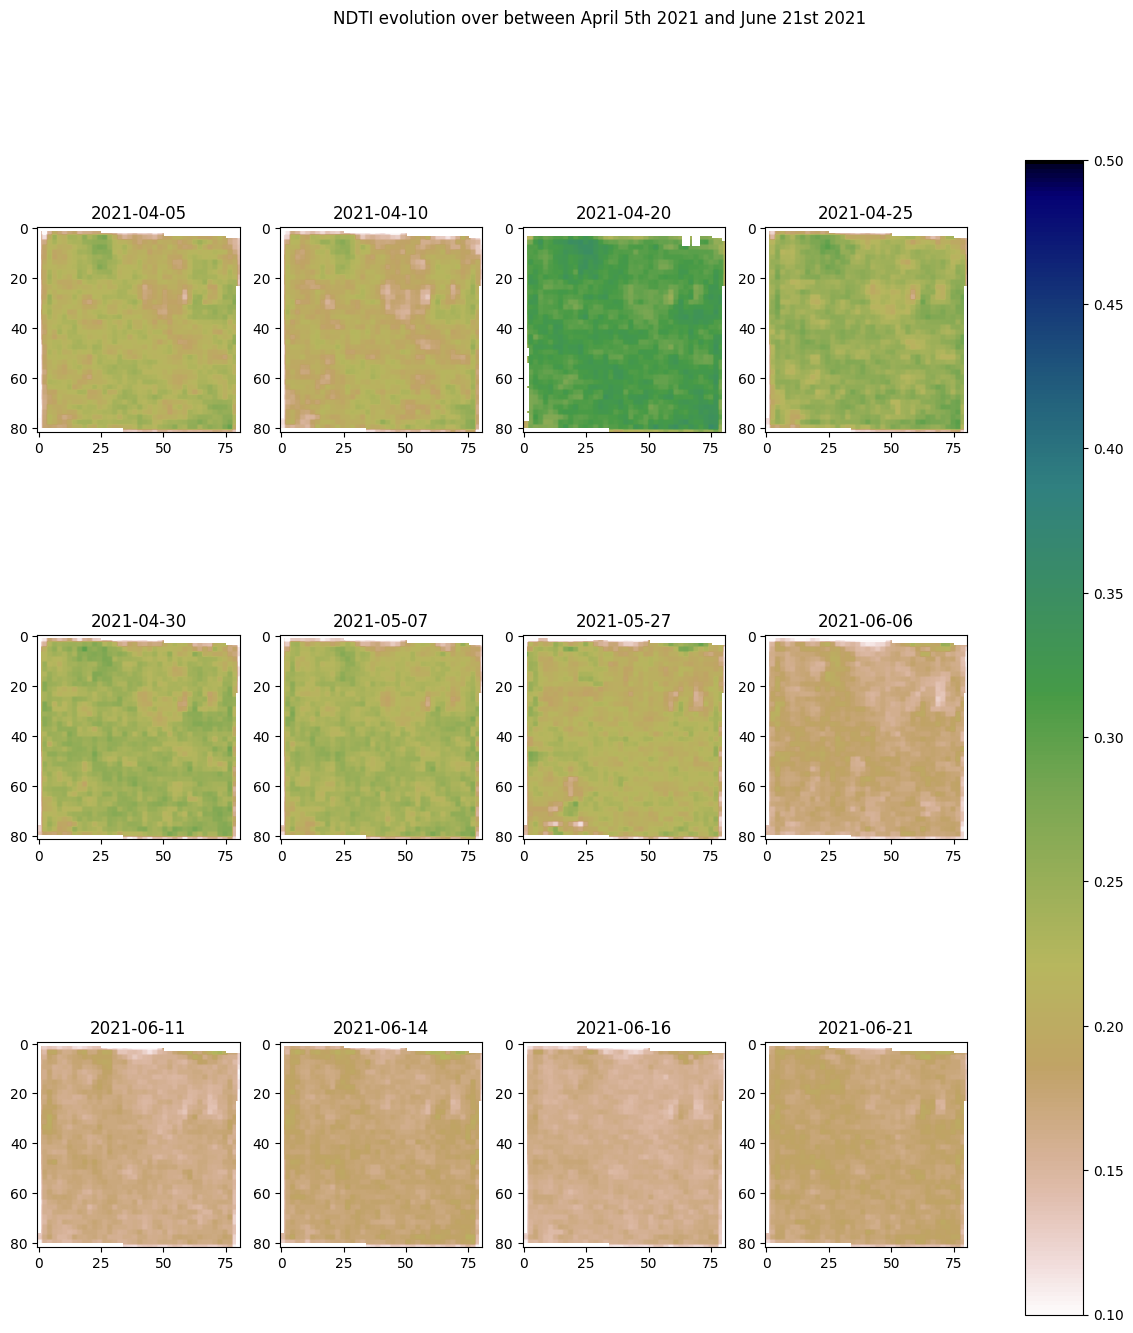

In [7]:
cmap = mpl.colormaps['gist_earth']
cmap_reversed = mpl.colormaps.get_cmap('gist_earth_r')

fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(15, 15))
fig.suptitle('NDTI evolution over between April 5th 2021 and June 21st 2021')
i=0
for ax in axes.flat:
    ax.set_title(str(dates[i])[0:10])
    im = ax.imshow(NDTIs[i],vmin=0.10,vmax=0.5,cmap=cmap_reversed)
    i+=1
    
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

 ## 3️⃣ Vegetation index time series

In [8]:
def NDVI(red,nir):
    return np.nanmedian((nir - red)/(nir + red))


In [9]:
dates=[]
NDVI_all_dates=[]
for date,cube_date in cube_date_int.groupby('time'):
    NDVI_all_dates.append(NDVI(cube_date.red,cube_date.nir08))
    dates.append(date)
print(len(NDVI_all_dates))

C:\Users\kls\AppData\Local\Temp\ipykernel_65720\1682466232.py:3: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for date,cube_date in cube_date_int.groupby('time'):


12


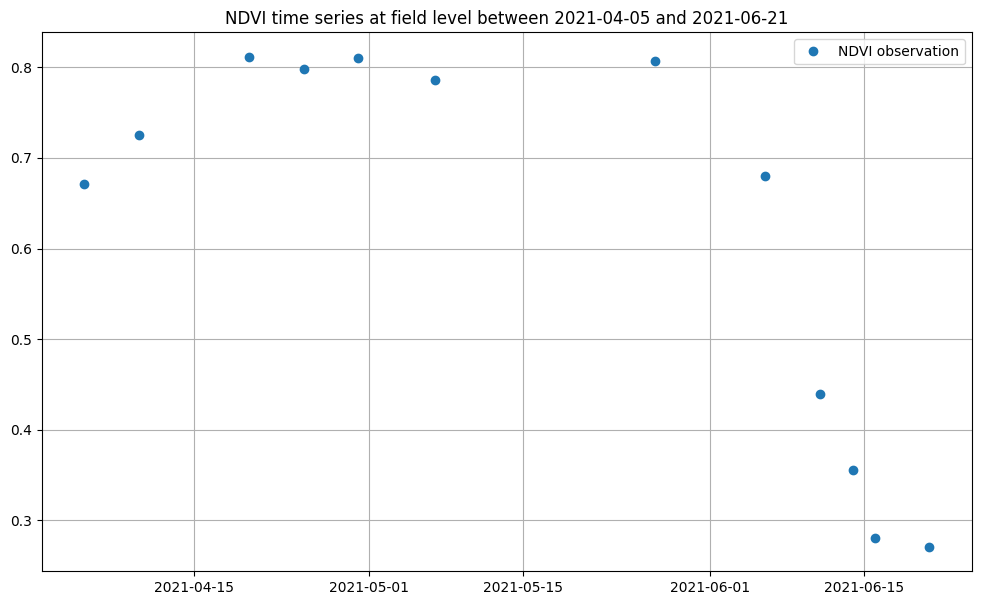

In [10]:
plt.figure(figsize=(12,7))
plt.title(f'NDVI time series at field level between {str(dates[0])[:10]} and {str(dates[-1])[:10]}')
plt.plot_date(dates,NDVI_all_dates,label='NDVI observation')
plt.legend()
plt.grid()


This plot is consistent with harvest then tillage at the beginning of June.